manual register upload for mira016.
close the web interface and shut down all jupyter kernels.

In [1]:
import cv2
import numpy as np
from typing import Optional, Tuple
import sys
import os
import pprint
import argparse
import time
import logging
import subprocess
from picamera2 import Picamera2, Preview
sys.path.append("../common")
#from picam2cv2 import CameraStreamInput
from driver_access import v4l2Ctrl
from config_parser import ConfigParser

In [2]:
from ipywidgets import interact, interactive
from IPython.display import display
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[20:33:18.451371073] [13781]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2023-10-21T22:05:29+02:00)
[20:33:18.455442381] [13798]  WARN CameraSensorProperties camera_sensor_properties.cpp:333 No static properties available for 'mira016'
[20:33:18.455483122] [13798]  WARN CameraSensorProperties camera_sensor_properties.cpp:335 Please consider updating the camera sensor properties database
[20:33:18.466960754] [13798]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[20:33:18.467945674] [13798]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[20:33:18.476814341] [13781]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 400x400-SGRBG10_CSI2P
[20:33:18.477117043] [13798]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unic

[{'bit_depth': 10,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (74, 1600421, None),
  'format': SGRBG10_CSI2P,
  'fps': 100.0,
  'size': (400, 400),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (74, 1600421, None),
  'format': SGRBG12_CSI2P,
  'fps': 100.0,
  'size': (400, 400),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (74, 1600421, None),
  'format': SGRBG8,
  'fps': 100.0,
  'size': (400, 400),
  'unpacked': 'SGRBG8'}]


# select mode here in the dropdown

In [3]:
def f(mode):
    display(mode)
    return mode
w = interactive(f, mode=modes)
display(w)

interactive(children=(Dropdown(description='mode', options=({'format': SGRBG10_CSI2P, 'unpacked': 'SGRBG10', '…

In [4]:
#ILLUMINATED CONDITIONS
# width=400
# height=400
# AeEnable=False
# FrameRate=50.0
# bit_depth=10
# ExposureTime = 1000
# AnalogueGain = 1

In [19]:
# Before stream on, upload register sequence
# Create a config parse to parse the register sequence txt
config_parser = ConfigParser()
#reg_seq = config_parser.parse_file('./config_files/Mira016_Register_Writes_10bit_360fps_1xgain.txt')
reg_seq = config_parser.parse_file('./config_files/10-bit mode_anagain1_30fps_exp1000us_datarate_800_mclk_242.txt')
print(f"Parsed {len(reg_seq)} register writes from file.")

# Create a v4l2Ctrl class for register read/write over i2c.
i2c = v4l2Ctrl(sensor="mira016", printFunc=print)

#########################################################
# Steps to upload reg sequence txt:
# (1) manually power off the sensor
# (3) manaully power on the sensor
# (3) disable reg upload and reset; force stream ctrl
# (4) upload register sequence
# (5) power off
#########################################################

# (1) Manually power off the sensor
print(f"Manually power off the sensor via V4L2 interface.")
i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_POWER_OFF)
time.sleep(3)

# (2) Manually power on the sensor
print(f"Manually power on the sensor via V4L2 interface.")
i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_POWER_ON)
time.sleep(1)

# (3) Disable base register sequence upload and sensor reset; force stream ctrl
i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_REG_UP_OFF)
i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_RESET_OFF)
i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_STREAM_CTRL_ON)

# (4) Upload register sequence from txt file
print(f"Writing {len(reg_seq)} registers to sensor via V4L2 interface. takes about 20 seconds due to overhead")
for reg in reg_seq:
    exp_val = i2c.rwReg(addr=reg[0], value=reg[1], rw=1, flag=0)
    time.sleep(0.001)
print('done')

Parsed 679 register writes from file.
Manually power off the sensor via V4L2 interface.
Manually power on the sensor via V4L2 interface.
Writing 679 registers to sensor via V4L2 interface. takes about 20 seconds due to overhead
done


In [20]:
exp_val = i2c.rwReg(addr=0xE000, value=0x1, rw=1, flag=0) # WRITE bank sel 1
time.sleep(0.001)

exp_val = i2c.rwReg(addr=0x0010, value=211, rw=1, flag=0)
time.sleep(0.001)
exp_val = i2c.rwReg(addr=0x0011, value=211, rw=1, flag=0)
time.sleep(0.001)
exp_val = i2c.rwReg(addr=0x00F, value=3, rw=1, flag=0)
time.sleep(0.001)

In [23]:
selected_mode = (w.result)
bit_mode = selected_mode["bit_depth"]
with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)
    
    picam2.start()
    
    image = picam2.capture_array("raw").view(np.uint16)
print(image)
print('great success')

[20:45:39.478735808] [13781]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2023-10-21T22:05:29+02:00)
[20:45:39.487009213] [18185]  WARN CameraSensorProperties camera_sensor_properties.cpp:333 No static properties available for 'mira016'
[20:45:39.487092879] [18185]  WARN CameraSensorProperties camera_sensor_properties.cpp:335 Please consider updating the camera sensor properties database
[20:45:39.506396552] [18185]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[20:45:39.507754577] [18185]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[20:45:39.515255859] [13781]  INFO Camera camera.cpp:1028 configuring streams: (0) 400x400-XBGR8888 (1) 400x400-SGRBG10
[20:45:39.515670707] [18185]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unicam for

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
great success


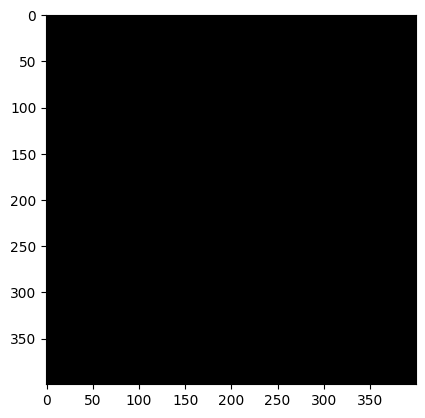

In [22]:
import matplotlib.pyplot as plt
plt.imshow(image,cmap='gray')
plt.show()

In [9]:
# revert all to normal
# i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_REG_UP_ON)
# i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_RESET_ON)
# i2c.rwReg(addr=0x0, value=0, rw=1, flag=i2c.AMS_CAMERA_CID_MIRA016_REG_FLAG_STREAM_CTRL_OFF)